In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torchvision.transforms import ToTensor
import tensorflow as tf
from torch.autograd import Variable
import torch.nn as nn
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, regularizers, layers
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split,StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
#calculate std
def get_standard_diviation(values):
  mean = np.mean(values)
  n = len(values)
  s = np.sqrt(np.sum((values-mean)**2)/(n-1))

  return s

# Get image data

In [ ]:
df_img = pd.read_csv("/content/gdrive/My Drive/Speciale/df_MRI_features_12042022", sep=",", header=0)
#df_img = pd.read_csv("C:/Users/python_test/Desktop/Speciale/df_MRI_features_12042022", sep=",", header=0)

df_img = df_img.set_index("id")
#df_img= df_img.drop(["v1: id"],axis=1)
df_img= df_img.drop(["Unnamed: 0"],axis=1)

#y = df_img["y"]

In [ ]:
var_of_interest = ["v1: Patella (vol)","v1: Medial Tibial (vol)","v1: Lateral Tibial (vol)","v1: Medial Femur (vol)",
                  "v1: Lateral Femur (vol)","v1: Medial Miniscus (vol)","v1: Lateral Miniscus (vol)","v1: JWS (approx)", 
                  "v1: Img Intensity (mean)","v1: Femur Intensity (median)","v1: Miniscus Intensity (median)","v1: Entropy Tibial",
                  "v1: Entropy Meniscus","v1: Entropy Femur","v1: Closing Femur","v1: Closing Tibial","v1: Closing Meniscus",
                  "v1: Thick Femur X","v1: Thick Femur Y","v1: Thick Femur Z","v1: Thick Tibial Y","v1: Thick Tibial Z",
                  "v1: Thick Meniscus X","v1: Thick Meniscus Y",
                  "v2: Patella (vol)","v2: Medial Tibial (vol)","v2: Lateral Tibial (vol)","v2: Medial Femur (vol)",
                  "v2: Lateral Femur (vol)","v2: Medial Miniscus (vol)","v2: Lateral Miniscus (vol)","v2: JWS (approx)", 
                  "v2: Img Intensity (mean)","v2: Femur Intensity (median)","v2: Miniscus Intensity (median)","v2: Entropy Tibial",
                  "v2: Entropy Meniscus","v2: Entropy Femur","v2: Closing Femur","v2: Closing Tibial","v2: Closing Meniscus",
                  "v2: Thick Femur X","v2: Thick Femur Y","v2: Thick Femur Z","v2: Thick Tibial Y","v2: Thick Tibial Z",
                  "v2: Thick Meniscus X","v2: Thick Meniscus Y",
                  "v3: Patella (vol)","v3: Medial Tibial (vol)","v3: Lateral Tibial (vol)","v3: Medial Femur (vol)",
                  "v3: Lateral Femur (vol)","v3: Medial Miniscus (vol)","v3: Lateral Miniscus (vol)","v3: JWS (approx)",
                  "v3: Img Intensity (mean)","v3: Femur Intensity (median)","v3: Miniscus Intensity (median)","v3: Entropy Tibial",
                  "v3: Entropy Meniscus","v3: Entropy Femur","v3: Closing Femur","v3: Closing Tibial","v3: Closing Meniscus",
                  "v3: Thick Femur X","v3: Thick Femur Y","v3: Thick Femur Z","v3: Thick Tibial Y","v3: Thick Tibial Z",
                  "v3: Thick Meniscus X","v3: Thick Meniscus Y",'y']
df_img = df_img[var_of_interest]
df_img["id"]=df_img.index

# Get clinical data

In [ ]:
df_clin = pd.read_csv("/content/gdrive/My Drive/Speciale/clindata_new_24052022", sep=",", header=0)
#df_clin = pd.read_csv("C:/Users/python_test/Desktop/Speciale/clindata_new_25042022", sep=",", header=0)
df_clin = df_clin.set_index("iD")
df_clin = df_clin.drop(["Unnamed: 0","y"],axis=1) #"Total Family History"
df_clin.index = [i.replace("_","-") for i in df_clin.index]
df_clin = df_clin.rename( index={'iD': 'id'})

# Merge the two data sets to one

In [ ]:
#df_clin= df_clin.drop_duplicates()
#df_img = df_img.drop_duplicates()

df_combi = df_clin.join(df_img).dropna()

In [ ]:
df_combi.columns.tolist()
col_order = ['Sex (V0)', 'Total Family History', 'Age (V1)', 'Lives w. Spouse(V0)','People in Household',
             'WOMAC Disability (v1)', 'WOMAC Pain (v1)', 'WOMAC Stiffness (v1)', 
             'Fall, 12 month (v1)', 'BMI (V1)', 'Upstairs,7 days (V1)', 'Out of bed, 7 days (V1)',
             'Socks off, 7 days (V1)', 'mod. lifestyle (V1)', 'PASE (V1)',
              'Broken bone (V1)',
              "v1: Patella (vol)","v1: Medial Tibial (vol)","v1: Lateral Tibial (vol)","v1: Medial Femur (vol)",
              "v1: Lateral Femur (vol)","v1: Medial Miniscus (vol)","v1: Lateral Miniscus (vol)","v1: JWS (approx)", 
              "v1: Img Intensity (mean)","v1: Femur Intensity (median)","v1: Miniscus Intensity (median)","v1: Entropy Tibial",
              "v1: Entropy Meniscus","v1: Entropy Femur","v1: Closing Femur","v1: Closing Tibial","v1: Closing Meniscus",
              "v1: Thick Femur X","v1: Thick Femur Y","v1: Thick Femur Z","v1: Thick Tibial Y","v1: Thick Tibial Z",
              "v1: Thick Meniscus X","v1: Thick Meniscus Y",
              'WOMAC Disability (v2)', 'WOMAC Pain (v2)','WOMAC Stiffness (v2)', 
              'Fall, 12 month (v2)', 'BMI (V2)','Upstairs,7 days (V2)', 'Out of bed, 7 days (V2)',
              'Socks off, 7 days (V2)', 'mod. lifestyle (V2)', 'PASE (V2)',
              'Broken bone (V2)',             
              "v2: Patella (vol)","v2: Medial Tibial (vol)","v2: Lateral Tibial (vol)","v2: Medial Femur (vol)",
              "v2: Lateral Femur (vol)","v2: Medial Miniscus (vol)","v2: Lateral Miniscus (vol)","v2: JWS (approx)", 
              "v2: Img Intensity (mean)","v2: Femur Intensity (median)","v2: Miniscus Intensity (median)","v2: Entropy Tibial",
              "v2: Entropy Meniscus","v2: Entropy Femur","v2: Closing Femur","v2: Closing Tibial","v2: Closing Meniscus",
              "v2: Thick Femur X","v2: Thick Femur Y","v2: Thick Femur Z","v2: Thick Tibial Y","v2: Thick Tibial Z",
              "v2: Thick Meniscus X","v2: Thick Meniscus Y",     
              'WOMAC Disability (v3)', 'WOMAC Pain (v3)','WOMAC Stiffness (v3)', 
              'Fall, 12 month (v3)', 'BMI (V3)','Upstairs, 7 days (V3)', 'Out of bed, 7 days (V3)',
              'Socks off, 7 days (V3)', 'Mod. lifestyle (V3)', 'PASE (V3)',
              "v3: Patella (vol)","v3: Medial Tibial (vol)","v3: Lateral Tibial (vol)","v3: Medial Femur (vol)",
              "v3: Lateral Femur (vol)","v3: Medial Miniscus (vol)","v3: Lateral Miniscus (vol)","v3: JWS (approx)", 
              "v3: Img Intensity (mean)","v3: Femur Intensity (median)","v3: Miniscus Intensity (median)","v3: Entropy Tibial",
              "v3: Entropy Meniscus","v3: Entropy Femur","v3: Closing Femur","v3: Closing Tibial","v3: Closing Meniscus",
              "v3: Thick Femur X","v3: Thick Femur Y","v3: Thick Femur Z","v3: Thick Tibial Y","v3: Thick Tibial Z",
              "v3: Thick Meniscus X","v3: Thick Meniscus Y",    
              'Broken bone (V3)',      
              'y', 'id']

df_combi = df_combi[col_order]

# Separate data and put aside

In [ ]:
# Seperate into training and validation 
TRAIN = pd.read_csv("/content/gdrive/My Drive/Speciale/matched_15032022", sep=",", header=0)
#TRAIN = pd.read_csv("C:/Users/python_test/Desktop/Speciale/matched_15032022", sep=",", header=0)

TRAIN = TRAIN.set_index("Unnamed: 0")
TRAIN = TRAIN.index

VAL = pd.read_csv("/content/gdrive/My Drive/Speciale/validation_15032022", sep=",", header=0)
#VAL = pd.read_csv("C:/Users/python_test/Desktop/Speciale/validation_15032022", sep=",", header=0)
VAL = VAL.set_index("Unnamed: 0")
VAL = VAL.index

In [ ]:
print("All img: ", df_combi.shape )

df_combi["id"] = [int(i[:7]) for i in df_combi.index]

# Select validation or training mode VAL or TRAIN
train = df_combi.loc[ df_combi['id'].isin(TRAIN)]
val = df_combi.loc[~df_combi['id'].isin(TRAIN)]

train = train.drop(["id"],axis=1)
val = val.drop(["id"],axis=1)

print("Train", train.shape)
print("Val", val.shape)
train.shape[0]+val.shape[0]

y = train["y"]
train= train.drop(["y"],axis=1)
x_flat = np.array(train.copy())

y_val = val["y"]
val= val.drop(["y"],axis=1)
x_flat_val = np.array(val.copy())

All img:  (1237, 112)
Train (1021, 111)
Val (216, 111)


# Split into data sets 

In [ ]:
k = 5
n = int((train.shape[1]-k)/3)

constants = train.iloc[:, :k]
# split into vitsits
v00 = (train.iloc[:,k:n+k])
v00 = pd.concat([constants, v00], axis=1)

v01 = (train.iloc[:,k+n:2*n+k])
v01 = pd.concat([constants, v01], axis=1)

v03 = (train.iloc[:, 2*n+k:])
v03 = pd.concat([constants, v03], axis=1)

### Also for validation
n = int((val.shape[1]-k)/3)

constants = val.iloc[:, :k]
# split into vitsits
v00_val = (val.iloc[:,k:n+k])
v00_val = pd.concat([constants, v00_val], axis=1)

v01_val = (val.iloc[:,k+n:2*n+k])
v01_val = pd.concat([constants, v01_val], axis=1)

v03_val = (val.iloc[:, 2*n+k:])
v03_val = pd.concat([constants, v03_val], axis=1)

In [ ]:
v00.shape, v01.shape, v03.shape, v00_val.shape, v01_val.shape, v03_val.shape

((1021, 40), (1021, 40), (1021, 40), (216, 40), (216, 40), (216, 40))

In [ ]:
#v00=v00.drop(columns=["Total Family History"])
#v01=v01.drop(columns=["Total Family History"])
#v03=v03.drop(columns=["Total Family History"])

#Combine 
df_all = np.array([v00,v01,v03])
df_all = np.moveaxis(df_all, 0, 1)

df_all.shape, y.shape

((1021, 3, 40), (1021,))

In [ ]:
#Combine 
df_all_val = np.array([v00_val,v01_val,v03_val])
df_all_val = np.moveaxis(df_all_val, 0, 1)

df_all_val.shape, y_val.shape

((216, 3, 40), (216,))

In [ ]:
pd.DataFrame(df_all.flatten()).to_csv("/content/gdrive/My Drive/Speciale/df_all_combined.csv")
y.to_csv("/content/gdrive/My Drive/Speciale/df_all_y.csv")

# Correlations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


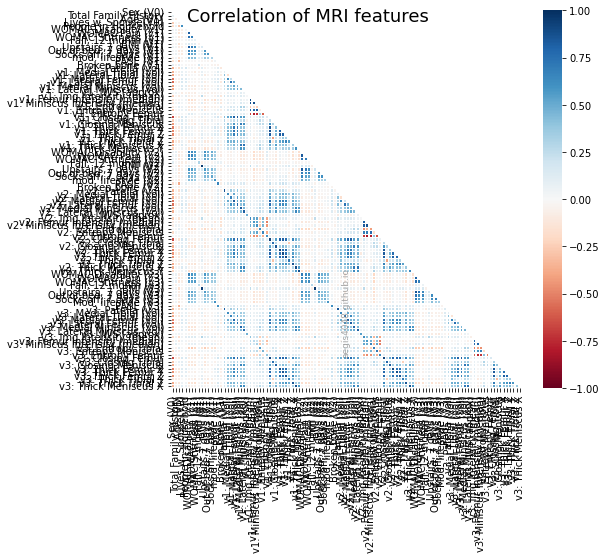

In [ ]:
import seaborn as sns
corr = train.iloc[:, :-2].corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(corr, mask=mask, cmap="RdBu", vmin=-1, vmax=1, center=0, linewidths=.3)

fig.suptitle('Correlation of MRI features', fontsize=18)
ax.text(0.5, 0.2, 'aegis4048.github.io', ha='center', va='center',
         transform=ax.transAxes, color='grey', alpha=0.7,rotation='vertical', fontsize=9)
#plt.rc('font', size = 11)
fig.set_size_inches((22 / 2.54, 20 / 2.54))

fig.tight_layout()
#fig.savefig('clincalfeat.png', dpi='figure')#,dpi=600)#, format='png')# , dpi=600)
fig.savefig('corrimage.pdf')  # Saving plot to pdf file
fig.show()
plt.rc('font', size = 11)

# Linear Regression

In [ ]:
X= np.array(train)
# make stratified KFOLD 
n_split=10
preds_stat=np.array([])

skf = StratifiedKFold(n_splits=n_split, shuffle=False)
mean = 0
data =[]
idxtests_stat = np.array([])
preds_stat = np.array([])

for train_index, test_index in skf.split(x_flat, y):
    Xtrain = X[train_index]
    ytrain = y[train_index]
    Xtest = X[test_index]
    ytest = y[test_index]
    
    #normalize data 
    m = np.mean(Xtrain,axis=0)
    std = np.std(Xtrain, axis =0)
    Xtrain = np.array((Xtrain - m )/std)
    Xtest = np.array((Xtest - m )/std)
    
    reg = LinearRegression().fit(Xtrain, ytrain)
    ypred = reg.predict(Xtest)
    ypred = np.where(ypred<0,0, ypred)

    idxtests_stat = np.concatenate([idxtests_stat,test_index])
    
    print("Accuracy Score: ", roc_auc_score(ytest.astype(float), ypred))
    mean += roc_auc_score(ytest.astype(float), ypred)
    data.append(roc_auc_score(ytest.astype(float), ypred))

    preds_stat = np.concatenate([preds_stat,ypred])

    
print("Mean accuracy score: ", mean/n_split)
print("Confidence interval: ", get_standard_diviation(data))
print("All: ", data)

Accuracy Score:  0.7582417582417582
Accuracy Score:  0.8877922077922078
Accuracy Score:  0.9283116883116883
Accuracy Score:  0.9096103896103896
Accuracy Score:  0.8358441558441558
Accuracy Score:  0.9475324675324676
Accuracy Score:  0.8592207792207792
Accuracy Score:  0.861842105263158
Accuracy Score:  0.8481781376518218
Accuracy Score:  0.6624493927125507
Mean accuracy score:  0.8499023082180976
Confidence interval:  0.08475495881186312
All:  [0.7582417582417582, 0.8877922077922078, 0.9283116883116883, 0.9096103896103896, 0.8358441558441558, 0.9475324675324676, 0.8592207792207792, 0.861842105263158, 0.8481781376518218, 0.6624493927125507]


In [ ]:
#    preds_stat = np.concatenate([preds_stat,np.squeeze(model.predict(Xtest))])
preds_stat.tofile("/content/gdrive/My Drive/Speciale/combined_MLinR.csv")
np.array(y).tofile("/content/gdrive/My Drive/Speciale/combined_y.csv")

In [ ]:
preds_stat.shape

(1021,)

### Validate

In [ ]:
#normalize data 
m = np.mean(x_flat,axis=0)
std = np.std(x_flat, axis =0)
x_flat = np.array((x_flat - m )/std)
x_flat_val = np.array((x_flat_val - m )/std)

# predict
reg = LinearRegression().fit(x_flat, y)
ypred = reg.predict(x_flat_val)
ypred = np.where(ypred<0,0, ypred)

print("Accuracy Score: ", roc_auc_score(y_val.astype(float), ypred))

Accuracy Score:  0.8691295546558706


# T-Statistics

In [ ]:
#One Big Model
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.20,shuffle=True)

m = np.mean(Xtrain,axis=0)
std = np.std(Xtrain, axis =0)
Xtrain_pd = (Xtrain - m )/std

Xtrain = np.array((Xtrain - m )/std)
Xtest_pd = (Xtest - m )/std
Xtest = np.array((Xtest - m )/std)

reg = LinearRegression().fit(Xtrain, ytrain)
ypred = reg.predict(Xtest)
ypred = np.where(ypred<0,0, ypred)
    
print("Accuracy Score: ", roc_auc_score(ytest, ypred))
#print("Coefficients: \n", reg.coef_)
print("incept", reg.intercept_)

Accuracy Score:  0.9038461538461539
incept 0.2475490196078489


### Calculate t-statistics

In [ ]:
# Get corefficients
params = reg.coef_

# Add row to constants
newX = pd.DataFrame({"Constant":np.ones(len(Xtest))}).join(pd.DataFrame(Xtest))

# #calculate std 
m = np.mean(newX, axis=0)
n = len(newX)
std = np.sqrt(np.sum((newX-m)**2, axis=0)/(n))

#Add incepts
params = np.append(reg.intercept_,params)

t_values = params/std

# set se of incept to 0
std[0] = 0
std=np.array(std)
t_values[0] = 0
t_values = np.array(t_values)

myDF3 = pd.DataFrame()
myDF3["Coefficients"]= params
myDF3["Standard Errors"] =std
myDF3["t values"] = t_values
names = ["incept"]+list(df_combi.columns[:-2])
myDF3=myDF3.set_index(pd.Index(names))
myDF3

,Coefficients,Standard Errors,t values
incept,0.247549,0.000000,inf
Sex (V0),0.015236,0.000000,0.000000
Total Family History,0.017393,1.033234,0.016834
Age (V1),-0.015933,0.996822,-0.015984
Lives w. Spouse(V0),0.037228,0.945361,0.039380
...,...,...,...
v3: Thick Tibial Y,-0.037179,1.003698,-0.037042
v3: Thick Tibial Z,-0.019316,0.999930,-0.019318
v3: Thick Meniscus X,0.013435,0.984338,0.013649
v3: Thick Meniscus Y,-0.064804,1.007231,-0.064339


In [ ]:
#PlAY
k = 5

importance = myDF3["t values"][1:]
n=int((len(importance)-k)/3)#round((len(importance))/2)
# Get variables, connect to weights (#Note remove id and labels)
#variables =myDF3.index[1:]#[i[:-4] for i in myDF3.index[1:]]
variables = [i[:-4] for i in myDF3.index[1:17]]+[i[4:] for i in myDF3.index[17:41]]

# plot histograms
plt.figure(figsize=(20 / 2.54, 15/ 2.54))
plt.bar([x+k for x in range(len(importance[k+1:n+k]))], importance[k+1:n+k], alpha=0.5, color="b",label="V1",edgecolor=None)
plt.bar([x+k for x in range(len(importance[n+k+1:2*n+k]))], importance[n+k+1:2*n+k], alpha=0.5, color="g",label="V2",edgecolor=None)
plt.bar([x+k for x in range(len(importance[2*n+k:]))], importance[2*n+k:], alpha=0.5, color="r",label="V3",edgecolor=None)

plt.bar([x for x in range(len(importance[1:k-1]))], importance[1:k-1], color="black",label="Static Variables",edgecolor=None)

plt.xticks([x for x in range(len(importance[:n+k]))], variables[:n+k], rotation =90) #, fontsize=5)
plt.plot(range(n+k+1), np.zeros(n+k+1), c="black")
plt.yscale('symlog')
#plt.gcf().subplots_adjust(left=0.2, bottom=0.45)
#plt.grid(True, linestyle='-.')
#plt.ylim([-0.2,0.2])
plt.tick_params(labelcolor='r')#, width=3) #labelsize=10
plt.ylabel("Feature importance")#,fontsize=8)
plt.title("Importance of clinical features") #fontsize = 12
plt.legend(loc="best") #fontsize=5
plt.tight_layout()

plt.savefig('Lincombi.pdf')  # Saving plot to pdf file


# LSTM model

Epoch 1/1500
30/30 [==============================] - 5s 37ms/step - loss: 5.1983 - auc: 0.4987 - val_loss: 5.1272 - val_auc: 0.6270
Epoch 2/1500
30/30 [==============================] - 1s 21ms/step - loss: 5.0378 - auc: 0.4990 - val_loss: 4.9906 - val_auc: 0.6278
Epoch 3/1500
30/30 [==============================] - 1s 21ms/step - loss: 4.8702 - auc: 0.5648 - val_loss: 4.8724 - val_auc: 0.6228
Epoch 4/1500
30/30 [==============================] - 1s 21ms/step - loss: 4.7290 - auc: 0.5045 - val_loss: 4.7648 - val_auc: 0.6280
Epoch 5/1500
30/30 [==============================] - 1s 23ms/step - loss: 4.5740 - auc: 0.5699 - val_loss: 4.6673 - val_auc: 0.6328
Epoch 6/1500
30/30 [==============================] - 1s 23ms/step - loss: 4.4513 - auc: 0.5130 - val_loss: 4.5773 - val_auc: 0.6356
Epoch 7/1500
30/30 [==============================] - 1s 20ms/step - loss: 4.3113 - auc: 0.5339 - val_loss: 4.4905 - val_auc: 0.6339
Epoch 8/1500
30/30 [==============================] - 1s 22ms/step - 

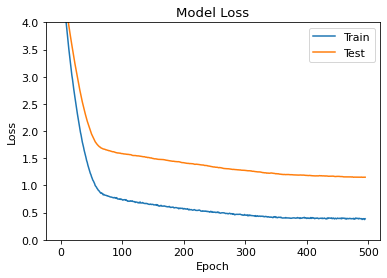

Epoch 1/1500
30/30 [==============================] - 4s 38ms/step - loss: 5.0061 - auc: 0.6152 - val_loss: 5.1199 - val_auc: 0.5830
Epoch 2/1500
30/30 [==============================] - 1s 24ms/step - loss: 4.8677 - auc: 0.6090 - val_loss: 5.0038 - val_auc: 0.6666
Epoch 3/1500
30/30 [==============================] - 1s 23ms/step - loss: 4.7264 - auc: 0.6024 - val_loss: 4.9069 - val_auc: 0.7000
Epoch 4/1500
30/30 [==============================] - 1s 21ms/step - loss: 4.5964 - auc: 0.5661 - val_loss: 4.8131 - val_auc: 0.7317
Epoch 5/1500
30/30 [==============================] - 1s 22ms/step - loss: 4.4541 - auc: 0.6414 - val_loss: 4.7227 - val_auc: 0.7410
Epoch 6/1500
30/30 [==============================] - 1s 23ms/step - loss: 4.3334 - auc: 0.5963 - val_loss: 4.6347 - val_auc: 0.7619
Epoch 7/1500
30/30 [==============================] - 1s 21ms/step - loss: 4.2003 - auc: 0.6387 - val_loss: 4.5489 - val_auc: 0.7725
Epoch 8/1500
30/30 [==============================] - 1s 22ms/step - 

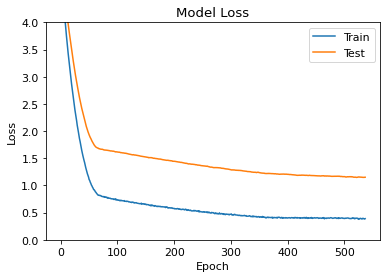

Epoch 1/1500
30/30 [==============================] - 4s 37ms/step - loss: 5.3475 - auc: 0.4386 - val_loss: 5.0730 - val_auc: 0.4016
Epoch 2/1500
30/30 [==============================] - 1s 23ms/step - loss: 5.1951 - auc: 0.4072 - val_loss: 4.9880 - val_auc: 0.3778
Epoch 3/1500
30/30 [==============================] - 1s 23ms/step - loss: 5.0126 - auc: 0.4213 - val_loss: 4.8980 - val_auc: 0.3756
Epoch 4/1500
30/30 [==============================] - 1s 23ms/step - loss: 4.8577 - auc: 0.4833 - val_loss: 4.8073 - val_auc: 0.3797
Epoch 5/1500
30/30 [==============================] - 1s 23ms/step - loss: 4.7090 - auc: 0.4828 - val_loss: 4.7176 - val_auc: 0.4034
Epoch 6/1500
30/30 [==============================] - 1s 23ms/step - loss: 4.5920 - auc: 0.4096 - val_loss: 4.6311 - val_auc: 0.4265
Epoch 7/1500
30/30 [==============================] - 1s 22ms/step - loss: 4.4400 - auc: 0.4367 - val_loss: 4.5448 - val_auc: 0.4518
Epoch 8/1500
30/30 [==============================] - 1s 24ms/step - 

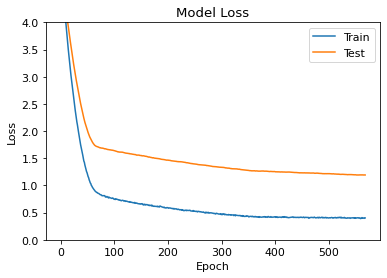

Epoch 1/1500
30/30 [==============================] - 4s 39ms/step - loss: 5.0015 - auc: 0.4305 - val_loss: 5.4065 - val_auc: 0.4609
Epoch 2/1500
30/30 [==============================] - 1s 22ms/step - loss: 4.8666 - auc: 0.4667 - val_loss: 5.3050 - val_auc: 0.4708
Epoch 3/1500
30/30 [==============================] - 1s 24ms/step - loss: 4.7210 - auc: 0.5022 - val_loss: 5.2071 - val_auc: 0.4702
Epoch 4/1500
30/30 [==============================] - 1s 25ms/step - loss: 4.5940 - auc: 0.4616 - val_loss: 5.1102 - val_auc: 0.4801
Epoch 5/1500
30/30 [==============================] - 1s 22ms/step - loss: 4.4709 - auc: 0.4595 - val_loss: 5.0128 - val_auc: 0.4964
Epoch 6/1500
30/30 [==============================] - 1s 25ms/step - loss: 4.3474 - auc: 0.4608 - val_loss: 4.9165 - val_auc: 0.5004
Epoch 7/1500
30/30 [==============================] - 1s 23ms/step - loss: 4.2201 - auc: 0.4859 - val_loss: 4.8229 - val_auc: 0.5277
Epoch 8/1500
30/30 [==============================] - 1s 26ms/step - 

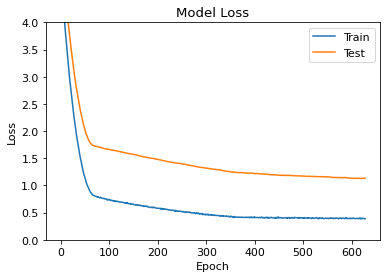

Epoch 1/1500
30/30 [==============================] - 4s 37ms/step - loss: 5.1619 - auc: 0.4433 - val_loss: 4.9897 - val_auc: 0.4941
Epoch 2/1500
30/30 [==============================] - 1s 23ms/step - loss: 5.0162 - auc: 0.4352 - val_loss: 4.9004 - val_auc: 0.4686
Epoch 3/1500
30/30 [==============================] - 1s 21ms/step - loss: 4.8722 - auc: 0.4066 - val_loss: 4.8178 - val_auc: 0.4668
Epoch 4/1500
30/30 [==============================] - 1s 24ms/step - loss: 4.7109 - auc: 0.4628 - val_loss: 4.7392 - val_auc: 0.4669
Epoch 5/1500
30/30 [==============================] - 1s 23ms/step - loss: 4.5576 - auc: 0.5100 - val_loss: 4.6627 - val_auc: 0.4763
Epoch 6/1500
30/30 [==============================] - 1s 22ms/step - loss: 4.4408 - auc: 0.4804 - val_loss: 4.5858 - val_auc: 0.4969
Epoch 7/1500
30/30 [==============================] - 1s 23ms/step - loss: 4.3094 - auc: 0.4840 - val_loss: 4.5096 - val_auc: 0.5236
Epoch 8/1500
30/30 [==============================] - 1s 22ms/step - 

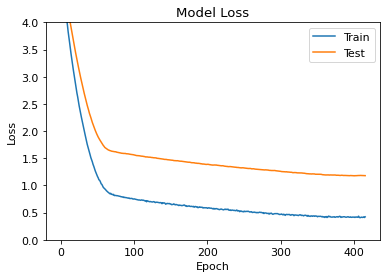

Epoch 1/1500
30/30 [==============================] - 4s 39ms/step - loss: 5.2139 - auc: 0.4594 - val_loss: 5.0405 - val_auc: 0.4264
Epoch 2/1500
30/30 [==============================] - 1s 23ms/step - loss: 5.0606 - auc: 0.4324 - val_loss: 4.9300 - val_auc: 0.4417
Epoch 3/1500
30/30 [==============================] - 1s 25ms/step - loss: 4.8952 - auc: 0.4741 - val_loss: 4.8251 - val_auc: 0.4659
Epoch 4/1500
30/30 [==============================] - 1s 23ms/step - loss: 4.7527 - auc: 0.4306 - val_loss: 4.7248 - val_auc: 0.4952
Epoch 5/1500
30/30 [==============================] - 1s 25ms/step - loss: 4.6068 - auc: 0.5001 - val_loss: 4.6311 - val_auc: 0.5215
Epoch 6/1500
30/30 [==============================] - 1s 24ms/step - loss: 4.4629 - auc: 0.5085 - val_loss: 4.5407 - val_auc: 0.5446
Epoch 7/1500
30/30 [==============================] - 1s 23ms/step - loss: 4.3354 - auc: 0.5217 - val_loss: 4.4539 - val_auc: 0.5585
Epoch 8/1500
30/30 [==============================] - 1s 23ms/step - 

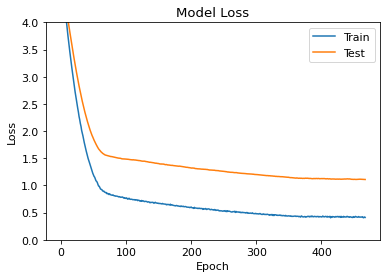

Epoch 1/1500
30/30 [==============================] - 4s 38ms/step - loss: 5.3280 - auc: 0.4776 - val_loss: 5.0301 - val_auc: 0.4463
Epoch 2/1500
30/30 [==============================] - 1s 25ms/step - loss: 5.1624 - auc: 0.5046 - val_loss: 4.9196 - val_auc: 0.4599
Epoch 3/1500
30/30 [==============================] - 1s 23ms/step - loss: 5.0078 - auc: 0.5094 - val_loss: 4.8138 - val_auc: 0.4780
Epoch 4/1500
30/30 [==============================] - 1s 25ms/step - loss: 4.8504 - auc: 0.5269 - val_loss: 4.7121 - val_auc: 0.5022
Epoch 5/1500
30/30 [==============================] - 1s 24ms/step - loss: 4.7076 - auc: 0.5486 - val_loss: 4.6142 - val_auc: 0.5266
Epoch 6/1500
30/30 [==============================] - 1s 24ms/step - loss: 4.5656 - auc: 0.5285 - val_loss: 4.5191 - val_auc: 0.5407
Epoch 7/1500
30/30 [==============================] - 1s 24ms/step - loss: 4.4301 - auc: 0.5605 - val_loss: 4.4275 - val_auc: 0.5478
Epoch 8/1500
30/30 [==============================] - 1s 23ms/step - 

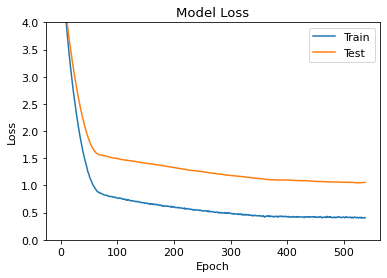

Epoch 1/1500
30/30 [==============================] - 7s 77ms/step - loss: 5.0009 - auc: 0.4913 - val_loss: 5.4369 - val_auc: 0.4859
Epoch 2/1500
30/30 [==============================] - 2s 51ms/step - loss: 4.8498 - auc: 0.5297 - val_loss: 5.3062 - val_auc: 0.5307
Epoch 3/1500
30/30 [==============================] - 2s 57ms/step - loss: 4.7240 - auc: 0.4736 - val_loss: 5.1837 - val_auc: 0.5572
Epoch 4/1500
30/30 [==============================] - 1s 43ms/step - loss: 4.5909 - auc: 0.5051 - val_loss: 5.0686 - val_auc: 0.5845
Epoch 5/1500
30/30 [==============================] - 1s 23ms/step - loss: 4.4646 - auc: 0.5084 - val_loss: 4.9554 - val_auc: 0.6095
Epoch 6/1500
30/30 [==============================] - 1s 25ms/step - loss: 4.3419 - auc: 0.4994 - val_loss: 4.8414 - val_auc: 0.6350
Epoch 7/1500
30/30 [==============================] - 1s 25ms/step - loss: 4.2133 - auc: 0.5569 - val_loss: 4.7418 - val_auc: 0.6495
Epoch 8/1500
30/30 [==============================] - 1s 23ms/step - 

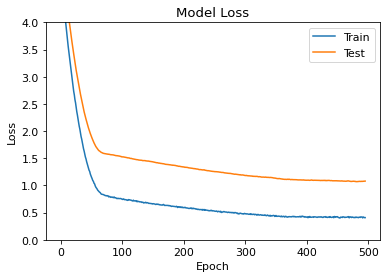

Epoch 1/1500
30/30 [==============================] - 4s 38ms/step - loss: 5.1516 - auc: 0.5052 - val_loss: 5.0067 - val_auc: 0.5127
Epoch 2/1500
30/30 [==============================] - 1s 26ms/step - loss: 4.9808 - auc: 0.5177 - val_loss: 4.9084 - val_auc: 0.4796
Epoch 3/1500
30/30 [==============================] - 1s 25ms/step - loss: 4.8391 - auc: 0.4914 - val_loss: 4.8145 - val_auc: 0.4798
Epoch 4/1500
30/30 [==============================] - 1s 26ms/step - loss: 4.6891 - auc: 0.5586 - val_loss: 4.7237 - val_auc: 0.4888
Epoch 5/1500
30/30 [==============================] - 1s 24ms/step - loss: 4.5534 - auc: 0.5327 - val_loss: 4.6355 - val_auc: 0.5051
Epoch 6/1500
30/30 [==============================] - 1s 25ms/step - loss: 4.4197 - auc: 0.5809 - val_loss: 4.5505 - val_auc: 0.5198
Epoch 7/1500
30/30 [==============================] - 1s 24ms/step - loss: 4.2926 - auc: 0.5516 - val_loss: 4.4665 - val_auc: 0.5381
Epoch 8/1500
30/30 [==============================] - 1s 24ms/step - 

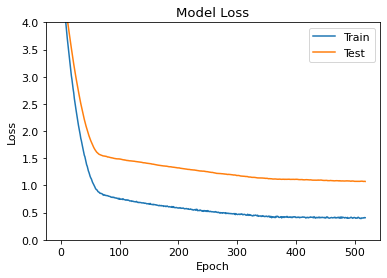

Epoch 1/1500
30/30 [==============================] - 4s 41ms/step - loss: 5.1214 - auc: 0.5536 - val_loss: 4.9467 - val_auc: 0.5331
Epoch 2/1500
30/30 [==============================] - 1s 24ms/step - loss: 4.9653 - auc: 0.5526 - val_loss: 4.8673 - val_auc: 0.5925
Epoch 3/1500
30/30 [==============================] - 1s 25ms/step - loss: 4.8131 - auc: 0.5380 - val_loss: 4.7874 - val_auc: 0.5887
Epoch 4/1500
30/30 [==============================] - 1s 26ms/step - loss: 4.6695 - auc: 0.5346 - val_loss: 4.7101 - val_auc: 0.5859
Epoch 5/1500
30/30 [==============================] - 1s 27ms/step - loss: 4.5289 - auc: 0.5500 - val_loss: 4.6352 - val_auc: 0.6162
Epoch 6/1500
30/30 [==============================] - 1s 25ms/step - loss: 4.3839 - auc: 0.5652 - val_loss: 4.5595 - val_auc: 0.6275
Epoch 7/1500
30/30 [==============================] - 1s 26ms/step - loss: 4.2543 - auc: 0.5780 - val_loss: 4.4859 - val_auc: 0.6402
Epoch 8/1500
30/30 [==============================] - 1s 26ms/step - 

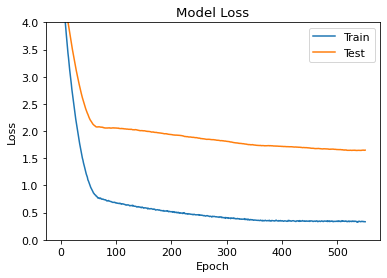

Mean acc:  0.8402359426021576
Confidence interval:  0.06592583849157453
All:  [0.8234265446662903, 0.8114286065101624, 0.907012939453125, 0.8490908741950989, 0.8514285683631897, 0.92311692237854, 0.8436363339424133, 0.8423582911491394, 0.8704453706741333, 0.6804149746894836]


In [ ]:
# define hyperparameters
dropout_rate = 0.30 
learning_rate = 0.0001
recurrent_rate = 0.30
n_split=10

x_tests_stat = []
preds_stat = []

l1_rate = 0.0075
l2_rate = 0.0075
mean = 0
accuracy = []
preds_stat = np.array([])

for train_index, test_index in skf.split(df_all, y):
    Xtrain = df_all[train_index]
    ytrain = y[train_index]
    Xtest = df_all[test_index]
    ytest = y[test_index]

    inputs = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))
    model = Sequential()

    x = layers.BatchNormalization(axis=-1,
                                 momentum=0.99,
                                 center =True,
                                 scale = True, 
                                 epsilon=0.0001)(inputs)

    x = layers.LSTM(30, #Bidirectional
                    activation ="sigmoid",
                    recurrent_activation = "sigmoid",
                    return_sequences=False,
                    kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_rate,
                    input_shape=(None, Xtrain.shape[1], Xtrain.shape[2]))(x)

    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation = "sigmoid")(x)  

    model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

    # define how to compile
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["AUC"], #,"Recall","accuracy"
        )
    
    history = model.fit(Xtrain, ytrain, epochs=1500, validation_split=0.20, verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=15), batch_size=25) #batch_size=75,monitor='val_loss'

    train_scores = model.evaluate(Xtrain, ytrain, verbose=2)
    test_scores = model.evaluate(Xtest, ytest, verbose=2)
    print("Train loss:", train_scores[0])
    print("Train accuracy:", train_scores[1])
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])
    accuracy.append(test_scores[1])

#    x_tests_stat.append(xtest)

    preds_stat = np.concatenate([preds_stat,np.squeeze(model.predict(Xtest))])
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Model Loss")
    plt.ylim([0,4])
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train","Test"],loc="best")
    plt.show()

print("Mean acc: ", np.mean(accuracy))
#create 95% confidence interval for population mean weight
print("Confidence interval: ", get_standard_diviation(accuracy) )
print("All: ", accuracy )



In [ ]:
preds_stat.tofile("/content/gdrive/My Drive/Speciale/combined_LSTM.csv")

In [ ]:
preds_stat.shape

(1021,)

In [ ]:
Mean acc:  0.8414553642272949
Confidence interval:  0.05672168317978605
All:  [0.8164335489273071, 0.8007792234420776, 0.8935065269470215, 0.8594805002212524, 0.8527272939682007, 0.9200000166893005, 0.8379220962524414, 0.8481781482696533, 0.8719635605812073, 0.7135627269744873]

SyntaxError: ignored

### Validate

Epoch 1/1500
33/33 [==============================] - 4s 35ms/step - loss: 5.0961 - auc: 0.2987 - val_loss: 5.2824 - val_auc: 0.3001
Epoch 2/1500
33/33 [==============================] - 1s 24ms/step - loss: 5.0073 - auc: 0.4011 - val_loss: 5.2488 - val_auc: 0.2837
Epoch 3/1500
33/33 [==============================] - 1s 23ms/step - loss: 4.9261 - auc: 0.3915 - val_loss: 5.2152 - val_auc: 0.2764
Epoch 4/1500
33/33 [==============================] - 1s 22ms/step - loss: 4.8439 - auc: 0.3961 - val_loss: 5.1770 - val_auc: 0.2715
Epoch 5/1500
33/33 [==============================] - 1s 23ms/step - loss: 4.7815 - auc: 0.3757 - val_loss: 5.1360 - val_auc: 0.2672
Epoch 6/1500
33/33 [==============================] - 1s 22ms/step - loss: 4.6997 - auc: 0.4029 - val_loss: 5.0916 - val_auc: 0.2744
Epoch 7/1500
33/33 [==============================] - 1s 22ms/step - loss: 4.6207 - auc: 0.4228 - val_loss: 5.0459 - val_auc: 0.2744
Epoch 8/1500
33/33 [==============================] - 1s 22ms/step - 

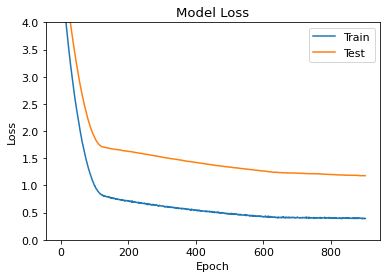

In [ ]:
# define hyperparameters
dropout_rate = 0.30 
learning_rate = 0.00005
recurrent_rate = 0.30
n_split=10

l1_rate = 0.0075
l2_rate = 0.0075


inputs = Input(shape=(df_all.shape[1], df_all.shape[2]))
model = Sequential()

x = layers.BatchNormalization(axis=-1,
                              momentum=0.99,
                              center =True,
                              scale = True, 
                              epsilon=0.0001)(inputs)

x = layers.LSTM(30, #Bidirectional
                activation ="sigmoid",
                recurrent_activation = "sigmoid",
                return_sequences=False,
                kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                dropout=dropout_rate, 
                recurrent_dropout=recurrent_rate,
                input_shape=(None, df_all.shape[1], df_all.shape[2]))(x)

x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)  

model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

# define how to compile
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["AUC"], #,"Recall","accuracy"
    )

history = model.fit(df_all, y, epochs=1500, validation_split=0.20, verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=15), batch_size=25) #batch_size=75,monitor='val_loss'

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylim([0,4])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="best")
plt.show()


In [ ]:
ypred = model.predict(df_all_val)
ypred = np.where(ypred<0,0, ypred)

print("Accuracy Score: ", roc_auc_score(y_val.astype(float), ypred))

Accuracy Score:  0.8908906882591094
